# 0. Introduction

**Dataset**  
- \-

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- 5-dimension(latent dim=5)의 random noise로부터 2-dim의 data point를 생성해내는 1D-GAN model을 구현

**References**
- [확률 분포와 GAN](https://youtu.be/AVvlDmhHgC4?si=sjzkdidTyzoHuQAi)

- GAN의 개념 및 변형 [ref1](https://medium.com/@hugmanskj/gan%EC%97%90-%EB%8C%80%ED%95%9C-%EC%9D%B4%ED%95%B4-a073a5425ef2) / [ref2](https://medium.com/@hugmanskj/hands-on-gan%EC%9D%98-%EC%9D%B4%ED%95%B4%EC%99%80-%EA%B5%AC%ED%98%84-866e03069995) / [ref3](https://medium.com/@hugmanskj/hands-on-conditional-gan%EC%9D%98-%EC%9D%B4%ED%95%B4%EC%99%80-%EA%B5%AC%ED%98%84-510b281f86d9) / [ref4](https://medium.com/@hugmanskj/gan%EC%9D%98-%EB%B3%80%ED%98%95%EB%93%A4-cgan-pix2pix-cyclegan-pix2pix-09a7a5a23002)

- [AI-class/1D_GAN2.ipynb at main · MyungKyuYi/AI-class](https://github.com/MyungKyuYi/AI-class/blob/main/1D_GAN2.ipynb)


In [1]:
import numpy as np

In [2]:
def generate_real_samples(n):
    x1 = np.random.rand(n) - 0.5 # generate a random number range (-0.5, 0.5)
    x2 = x1 ** 3                 # generate outputs
    
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)

    X = np.hstack((x1, x2))      # stacked layers
    y = np.ones((n, 1))          # generate class label

    return X, y

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.utils import plot_model
import matplotlib.pyplot as plt

2024-11-13 19:02:17.309564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def define_discriminator(inputs=2):
    model = Sequential(name='Discriminator')
    # 25 dense
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=inputs))
    model.add(LeakyReLU(alpha=0.01))
    # 15 dense
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    # 5 dense
    model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    # discriminator는 fake or real 구분을 해야 하므로 마지막에 sigmoid layer 추가
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
discriminator_model = define_discriminator()
discriminator_model.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)               

2024-11-13 19:02:24.060873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def define_generator(latent_dim, outputs=2):
    '''
    real image에 대한 latent space로부터 fake를 생성하는 모델
    즉 latent space를 입력으로 받음
    '''
    model = Sequential(name='Generator')
    # 25 dense
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(outputs, activation='linear'))

    return model

In [7]:
latent_dim = 5
generator_model = define_generator(latent_dim)
generator_model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                150       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 15)                390       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 32        
                                                                 
Total params: 572
Trainable params: 572
Non-trainable params: 0
_________________________________________________________________


In [8]:
def generate_latent_points(latent_dim, n):
    '''generate points in latent space as input for the generator'''
    x_input = np.random.rand(latent_dim*n) #generate points in latent space
    x_input = x_input.reshape(n,latent_dim)  #reshape
    return x_input

def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n) #genarate points in latent space
    x = generator.predict(x_input) #predict outputs
    y = np.zeros((n, 1))
    return x, y

4/4 [==============================] - 0s 1ms/step


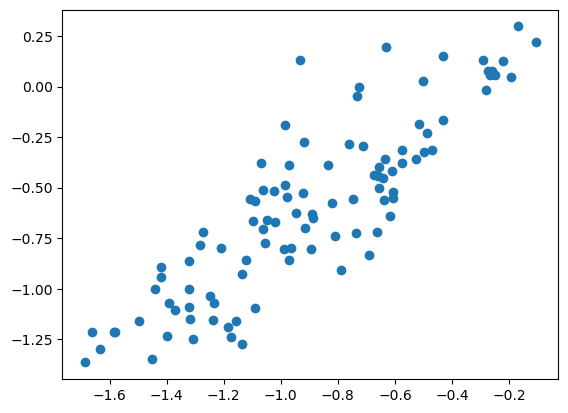

In [9]:
X, _ = generate_fake_samples(generator_model, latent_dim, 100)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [10]:
# generator와 discriminator를 붙인 것이 결국 GAN이다.
def define_gan(generator, discriminator):
    '''define the combined generator and discriminator model'''
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    return model

In [11]:
gan_model = define_gan(generator_model, discriminator_model)
gan_model.summary()

# 'sequential_1' layer is Generator
# 'sequential'   layer is Discriminator

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 2)                 572       
                                                                 
 Discriminator (Sequential)  (None, 1)                 551       
                                                                 
Total params: 1,123
Trainable params: 572
Non-trainable params: 551
_________________________________________________________________


In [12]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n = 100):
    '''evaluate the discriminator and plot real and fake samples'''
    x_real, y_real = generate_real_samples(n)      #generate real samples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1)
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

In [13]:
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs = 10000,num_eval = 2000, batch_size = 128):
    ''' function to train gan model'''
    half_batch = int(batch_size/2)
  #run epochs
    for i in range(num_epochs):
        X_real, y_real = generate_real_samples(half_batch) #generate real examples
        d_model.train_on_batch(X_real, y_real)               # train on real data
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) #generate fake samples
        d_model.train_on_batch(X_fake, y_fake)                #train on fake data
        #prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, batch_size)
        y_gan = np.ones((batch_size, 1))    #generate fake labels for gan
        gan_model.train_on_batch(x_gan, y_gan)
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

4/4 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.8200
Epoch: 2000 Real Acc.: 0.6499999761581421 Fake Acc.: 0.8199999928474426


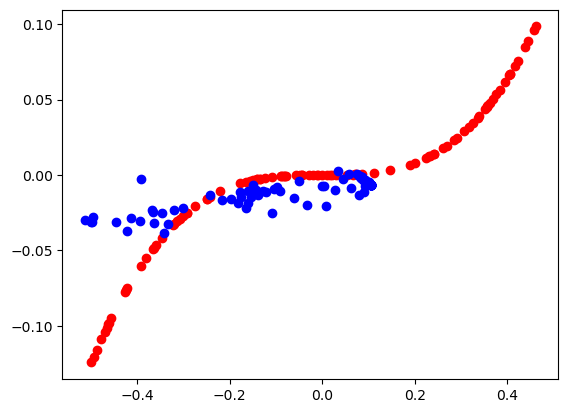

4/4 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.6200
Epoch: 4000 Real Acc.: 0.5400000214576721 Fake Acc.: 0.6200000047683716


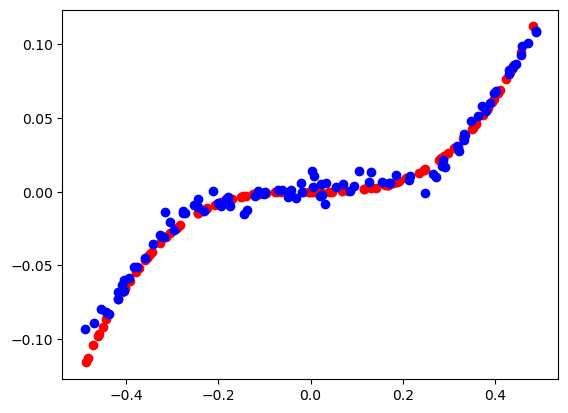

4/4 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.6400
Epoch: 6000 Real Acc.: 0.5600000023841858 Fake Acc.: 0.6399999856948853


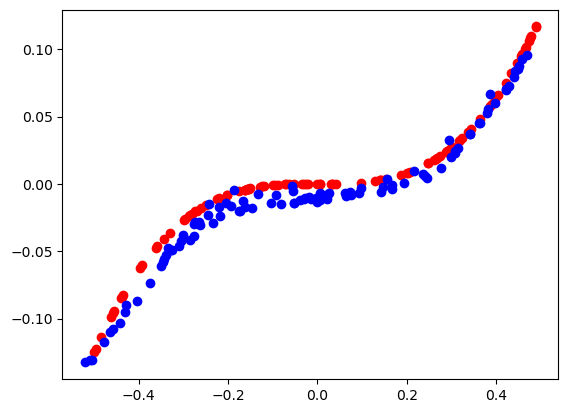

4/4 [==============================] - 0s 2ms/step - loss: 0.6763 - accuracy: 0.8400
Epoch: 8000 Real Acc.: 0.7300000190734863 Fake Acc.: 0.8399999737739563


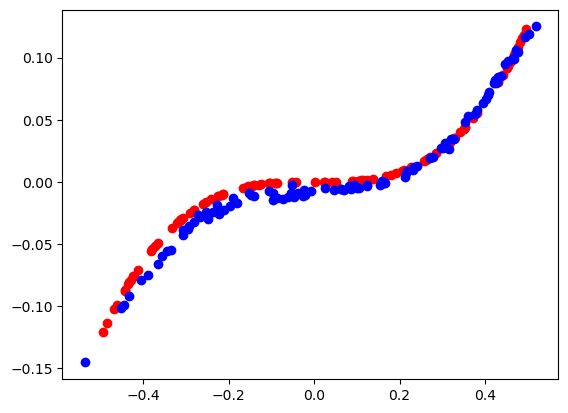

4/4 [==============================] - 0s 1ms/step - loss: 0.7165 - accuracy: 0.4100
Epoch: 10000 Real Acc.: 0.6100000143051147 Fake Acc.: 0.4099999964237213


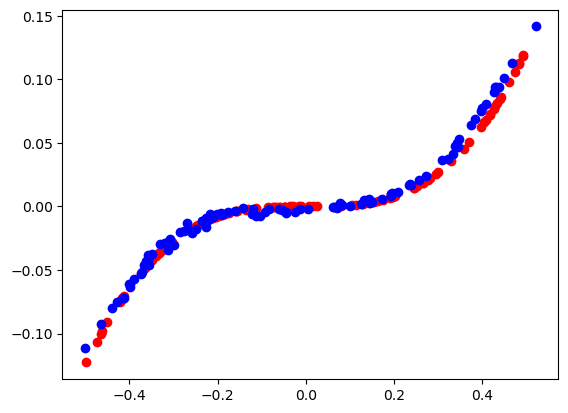

In [14]:
train_gan(generator_model, discriminator_model, gan_model, latent_dim)